In [41]:
from git import Repo
import shutil
import os
import glob
from shutil import copyfile
import os
import fnmatch
import os
import requests
import json
import matplotlib.pyplot as plt  # To visualize
import numpy
import pygount
from sklearn.linear_model import LinearRegression
from pyquery import PyQuery 
import locale

import pandas as pd
dtypes = numpy.dtype([
          ('Repo', str),
          ('Eslint Errors per 100 lines', float),
          ('Stars', int),
          ('Lines of code', int),
           ('Contributors', int),
    ('Test Lib', str),
    ('Coverage', float)
          ])
data = numpy.empty(0, dtype=dtypes)
df = pd.DataFrame(data)

# Future work
#  1. Find out a way to use existing eslint config in the repos. The main problem we run into is the extends
#     but maybe there is a way to download the extends in the script
#  2. Find out number of contributors. some funny things going on with pagination when you try /stats/contributors

In [42]:
def lines_of_code_counter():
    #!/usr/bin/env python

    # This Python script counts the lines of code in the directory in which it is
    # run.  It only looks at files which end in the file extensions passed to the
    # script as arguments.

    # It outputs counts for total lines, blank lines, comment lines and code lines
    # (total lines minus blank lines and comment lines).

    # Example usage and output:
    # > lines_of_code_counter.py .h .cpp
    # Total lines:   15378
    # Blank lines:   2945
    # Comment lines: 1770
    # Code lines:    10663

    # Change this value based on the comment symbol used in your programming
    # language.
    commentSymbol = "//"

    import sys
    import os, os.path

    acceptableFileExtensions = [".js"]
    if not acceptableFileExtensions:
        print('Please pass at least one file extension as an argument.')
        quit()

    currentDir = os.getcwd()

    filesToCheck = []
    for root, _, files in os.walk(currentDir):
        for f in files:
            fullpath = os.path.join(root, f)
            if '.git' not in fullpath:
                for extension in acceptableFileExtensions:
                    if fullpath.endswith(extension):
                        filesToCheck.append(fullpath)

    if not filesToCheck:
        print('No files found.')
        quit()

    lineCount = 0
    totalBlankLineCount = 0
    totalCommentLineCount = 0

#     print('')
#     print('Filename\tlines\tblank lines\tcomment lines\tcode lines')

    for fileToCheck in filesToCheck:
        with open(fileToCheck) as f:

            fileLineCount = 0
            fileBlankLineCount = 0
            fileCommentLineCount = 0

            for line in f:
                lineCount += 1
                fileLineCount += 1

                lineWithoutWhitespace = line.strip()
                if not lineWithoutWhitespace:
                    totalBlankLineCount += 1
                    fileBlankLineCount += 1
                elif lineWithoutWhitespace.startswith(commentSymbol):
                    totalCommentLineCount += 1
                    fileCommentLineCount += 1

#             print(os.path.basename(fileToCheck) + \
#                   "\t" + str(fileLineCount) + \
#                   "\t" + str(fileBlankLineCount) + \
#                   "\t" + str(fileCommentLineCount) + \
#                   "\t" + str(fileLineCount - fileBlankLineCount - fileCommentLineCount))


#     print('')
#     print('Totals')
#     print('--------------------')
#     print('Lines:         ' + str(lineCount))
#     print('Blank lines:   ' + str(totalBlankLineCount))
#     print 'Comment lines: ' + str(totalCommentLineCount)
#     print('Code lines:    ' + str(lineCount - totalBlankLineCount - totalCommentLineCount))
    return (lineCount - totalBlankLineCount - totalCommentLineCount)

In [50]:
js_repos = [
#     "/reduxjs/redux", 
#             "/angular/angular",
#             "/zalmoxisus/redux-devtools-extension",
#             "/facebook/react-native",
            "/electron/electron",
           "/faceyspacey/redux-first-router",
            "/faceyspacey/redux-first-router-link",
            "/reduxjs/redux-thunk",
            "/googlechrome/workbox",
            "/cypress-io/cypress",
            "/airbnb/enzyme",
            "/expressjs/express",
            "/vuejs/vue",
            "/wheresrhys/fetch-mock",
            "/facebook/jest",
            "/bitinn/node-fetch",
            "/prettier/prettier",
            "/pinterest/service-workers",
            "/bahmutov/start-server-and-test",
            "/webpack/webpack-dev-server",
            "/facebook/react",
            "/eduardoboucas/include-media",
            "/insin/inputmask-core",
            "/dankogai/js-base64",
            "/lodash/lodash",
            "/moment/moment",
            "/blakeembrey/pluralize",
            "/taylorhakes/promise-polyfill",
            "/facebook/prop-types",
            "/sindresorhus/query-string"
           ]
# js_repos = ["/reduxjs/redux"]

for js_repo in js_repos:
    cloned_repo_dir = "/Users/gmholden/workspace/code_health_analysis/cloned_repo"
    
    print("Looking for number of contributors..")
    html = requests.get("https://github.com" + js_repo)
    e = PyQuery(html.content)
    links = e('li')
    for link in links:
        if("contributors" in PyQuery(link).html()):
            items = PyQuery(link).items('span')
            for i in items:
                if "Fetching" in str(i):
                    contributors = float('nan')
                    break
                locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
                contributors = locale.atoi(i.text())
                print(contributors)
    
    print("cleaning out any files in repo directory")
    if os.path.exists(cloned_repo_dir):
        for root, dirs, files in os.walk(cloned_repo_dir):
            for f in files:
                os.unlink(os.path.join(root, f))
            for d in dirs:
                shutil.rmtree(os.path.join(root, d)) 
    
    print("Cloning down " + js_repo)
    Repo.clone_from("https://github.com" + js_repo, cloned_repo_dir)
    os.chdir(cloned_repo_dir)
    
    print("counting lines of code..")
    lines_of_code = lines_of_code_counter()
    print(lines_of_code)
    
    print("Finding out what type of test runner they are using..")
    data = open(cloned_repo_dir + "/package.json").read()
    if "jest" in data:
        runner = "jest"
        print(runner)

        results = os.popen('npm install').read()
        results = os.popen("npm test -- --coverage").read()
        results_arr = results.splitlines()
        results_line = filter(lambda x: ("All files" in x), results_arr)
        try:
            line = list(results_line)[0]
            print("coverage line:" + line)
            coverage = line.split('|')[4].strip()
            coverage = float(coverage)
        except:
            coverage = float('nan')
        print(coverage)  
    elif "mocha" in data:
        runner = "mocha"
        coverage = float('nan')
        print(runner)
    else:
        runner = "unknown"
        print(runner)
        coverage = float('nan')
    
    print("destroying any existing eslint config")
    filePattern = cloned_repo_dir + '/*eslintrc*'
    matches = []
    for root, dirnames, filenames in os.walk(cloned_repo_dir):
        for filename in fnmatch.filter(filenames, '*eslintrc*'):
            matches.append(os.path.join(root, filename))
    for filePath in matches:
        try:
            os.remove(filePath)
        except OSError:
            print("Error while deleting file")
    print("finished deleting all existing eslint config")
    
    print("running eslint..")
    os.chdir('..')
    current_path = os.path.abspath('')
    filename = os.path.join(current_path, '.eslintrc.js')
    copyfile(filename, cloned_repo_dir + "/.eslintrc.js")
    results = os.popen('/Users/gmholden/.nvm/versions/node/v10.15.3/bin/eslint cloned_repo').read()
    lines = results.splitlines()
    error_line = lines[-3:-1]
    s = ' '
    print("error line:" + s.join(error_line))
    try:
        errors = s.join(error_line).split('(')[1].split(',')[0].split(' ')[0]
    except:
        errors = float('nan')
    print("errors: " + str(errors))
        
    print("Looking for number of stars..")
    json_contents = requests.get("http://api.github.com/repos" + js_repo).json()
    stars = json_contents['watchers']
    print(stars)

    df = df.append({'Repo' : js_repo , 
                    'Eslint Errors per 100 lines' : float(errors)/(float(lines_of_code)/100), 
                    'Stars': int(stars), 
                    'Lines of code': lines_of_code ,
                    'Contributors': contributors,
                    'Test Lib': runner,
                    'Coverage': coverage},
                   ignore_index=True)
    
   

Looking for number of contributors..
880
cleaning out any files in repo directory
Cloning down /electron/electron
counting lines of code..
17221
Finding out what type of test runner they are using..
mocha
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
error line: ✖ 1987 problems (1987 errors, 0 warnings)
errors: 1987
Looking for number of stars..
76793
Looking for number of contributors..
cleaning out any files in repo directory
Cloning down /faceyspacey/redux-first-router
counting lines of code..
6787
Finding out what type of test runner they are using..
jest
coverage line:All files                           |    91.44 |    84.52 |    86.96 |    92.22 |                   |
92.22
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
error line:
errors: nan
Looking for number of stars..
1480
Looking for number of contributors..
cleaning out any files in repo directory
Cloning down /faceysp

cleaning out any files in repo directory
Cloning down /dankogai/js-base64
counting lines of code..
391
Finding out what type of test runner they are using..
mocha
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
error line:✖ 93 problems (93 errors, 0 warnings)   1 error and 0 warnings potentially fixable with the `--fix` option.
errors: 93
Looking for number of stars..
2513
Looking for number of contributors..
285
cleaning out any files in repo directory
Cloning down /lodash/lodash
counting lines of code..
29575
Finding out what type of test runner they are using..
mocha
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
error line: ✖ 2649 problems (2649 errors, 0 warnings)
errors: 2649
Looking for number of stars..
41307
Looking for number of contributors..
488
cleaning out any files in repo directory
Cloning down /moment/moment
counting lines of code..
160119
Finding out what type of t

In [47]:
dtypes = numpy.dtype([
          ('Repo', str),
          ('Eslint Errors per 100 lines', float),
          ('Stars', int),
          ('Lines of code', int),
           ('Contributors', int),
    ('Test Lib', str),
    ('Coverage', float)
          ])
data = numpy.empty(0, dtype=dtypes)
df_master = pd.DataFrame(data)
df_master = df_master.append(df, ignore_index = True)
df_master

,Repo,Eslint Errors per 100 lines,Stars,Lines of code,Contributors,Test Lib,Coverage
0,/reduxjs/redux,NaN,50493,5728,698,jest,97.53
1,/angular/angular,7.778469,51311,143023,989,unknown,NaN
2,/zalmoxisus/redux-devtools-extension,2.497371,9884,11412,58,mocha,NaN
3,/facebook/react-native,NaN,80786,245623,2004,jest,6.97


In [51]:
df

,Repo,Eslint Errors per 100 lines,Stars,Lines of code,Contributors,Test Lib,Coverage
0,/reduxjs/redux,NaN,50493,5728,698.0,jest,97.53
1,/angular/angular,7.778469,51311,143023,989.0,unknown,NaN
2,/zalmoxisus/redux-devtools-extension,2.497371,9884,11412,58.0,mocha,NaN
3,/facebook/react-native,NaN,80786,245623,2004.0,jest,6.97
4,/electron/electron,11.538238,76793,17221,880.0,mocha,NaN
5,/faceyspacey/redux-first-router,NaN,1480,6787,NaN,jest,92.22
6,/faceyspacey/redux-first-router-link,NaN,55,11637,NaN,jest,96.15
7,/reduxjs/redux-thunk,14.843750,13091,128,37.0,mocha,NaN
8,/googlechrome/workbox,6.469401,8198,14870,46.0,mocha,NaN
9,/cypress-io/cypress,13.072049,14520,55393,111.0,mocha,NaN


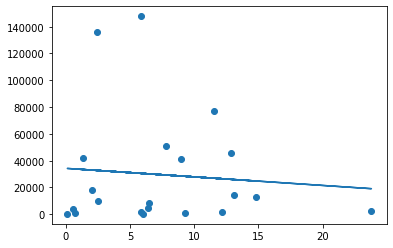

In [52]:
df2 = df.dropna(subset=['Eslint Errors per 100 lines']) # drop rows with nan 
X = pd.DataFrame(df2['Eslint Errors per 100 lines'])
y = pd.DataFrame(df2['Stars'])

model = LinearRegression()
model.fit(X, y)

Y_pred = model.predict(X)  # make predictions
plt.scatter(X , y)
plt.plot(X, Y_pred)

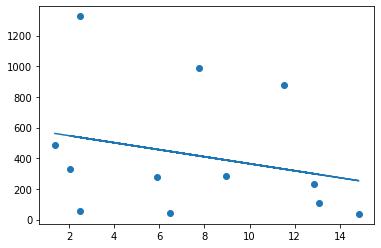

In [53]:
df2 = df.dropna(subset=['Contributors', 'Eslint Errors per 100 lines']) # drop rows with nan for contributors
X = pd.DataFrame(df2['Eslint Errors per 100 lines'])
y = pd.DataFrame(df2['Contributors'])

model = LinearRegression()
model.fit(X, y)

Y_pred = model.predict(X)  # make predictions
plt.scatter(X , y)
plt.plot(X, Y_pred)


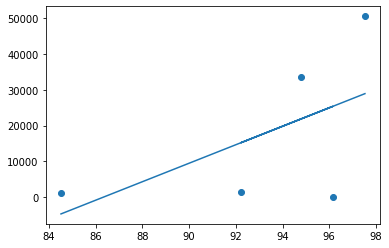

In [61]:
df2 = df.dropna(subset=['Coverage']) # drop rows with nan for coverage
df2 = df2.drop([3]) # drop outlier react native until further investigation
X = pd.DataFrame(df2['Coverage'])
y = pd.DataFrame(df2['Stars'])

model = LinearRegression()
model.fit(X, y)

Y_pred = model.predict(X)  # make predictions
plt.scatter(X , y)
plt.plot(X, Y_pred)